In [45]:
import torch
import torch.nn as nn
import torch.optim as optimization
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as data
import matplotlib.pyplot as plt
import numpy as np

from torchsummary import summary

# 28x28
train_dataset = data.MNIST(root='./data', train=True,
                           transform=transforms.ToTensor(), download=True)

test_dataset = data.MNIST(root='./data', train=False,
                          transform=transforms.ToTensor())

batch_size = 32
n_iters = 10000
num_epochs = n_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)


In [27]:
class Trainer(object):
    def __init__(self, train_dataset, test_dataset, model, num_epochs, batch_size, learning_rate):
        self.train_loader = train_dataset
        self.test_loader = test_dataset
        self.model = model
        self.num_epochs = num_epochs
        self.batch_size = batch_size
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = optimization.Adam(self.model.parameters(), lr=learning_rate)
        self.train_state = {
            'done_training': False,
            'stop_early': False,
            'early_stopping_step': 0,
            'early_stopping_best_val': 1e8,
            'learning_rate': learning_rate,
            'epoch_index': 0,
            'train_loss': [],
            'train_acc': [],
            'val_loss': [],
            'val_acc': [],
            'test_loss': -1,
            'test_acc': -1}

    def update_train_state(self):
        # Verbose
        print("[EPOCH]: {0} | [LR]: {1} | [TRAIN LOSS]: {2:.2f} | [TRAIN ACC]: {3:.1f}% | [VAL LOSS]: {4:.2f} | [VAL ACC]: {5:.1f}%".format(
            self.train_state['epoch_index'], self.train_state['learning_rate'],
            self.train_state['train_loss'][-1], self.train_state['train_acc'][-1],
            self.train_state['val_loss'][-1], self.train_state['val_acc'][-1]))

    def compute_accuracy(self, outputs, target):
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == target).sum()
        accuracy = 100 * correct / len(predicted)
        return accuracy

    def run_train_loop(self):
        for epoch_index in range(self.num_epochs):
            self.train_state['epoch_index'] = epoch_index

            # Iterate over train dataset
            running_loss = 0.0
            running_acc = 0.0
            self.model.train()

            for i, (images, labels) in enumerate(train_loader):
                images = images.requires_grad_()
                # zero the gradients
                self.optimizer.zero_grad()

                # compute the output
                outputs = self.model(images)

                # compute the loss
                loss = self.criterion(outputs, labels)
                loss_t = loss.item()
                running_loss += (loss_t - running_loss) / (i + 1)

                # compute gradients using loss
                loss.backward()

                # use optimizer to take a gradient step
                self.optimizer.step()

                # compute the accuracy
                acc_t = self.compute_accuracy(outputs, labels)
                running_acc += (acc_t - running_acc) / (i + 1)

            self.train_state['train_loss'].append(running_loss)
            self.train_state['train_acc'].append(running_acc)

            # Iterate over val dataset
            running_loss = 0.
            running_acc = 0.
            self.model.eval()

            for i, (images, labels) in enumerate(test_loader):
                # compute the output
                outputs = self.model(images)

                # compute the loss
                loss = self.criterion(outputs, labels)
                loss_t = loss.item()
                running_loss += (loss_t - running_loss) / (i + 1)

                # compute the accuracy
                acc_t = self.compute_accuracy(outputs, labels)
                running_acc += (acc_t - running_acc) / (i + 1)

            self.train_state['val_loss'].append(running_loss)
            self.train_state['val_acc'].append(running_acc)

            self.update_train_state()


    def run_test_loop(self):
        running_loss = 0.0
        running_acc = 0.0
        self.model.eval()

        for i, (images, labels) in enumerate(test_loader):
            # compute the output
            outputs = self.model(images)

            # compute the loss
            loss = self.criterion(outputs, labels)
            loss_t = loss.item()
            running_loss += (loss_t - running_loss) / (i + 1)

            # compute the accuracy
            acc_t = self.compute_accuracy(outputs, labels)
            running_acc += (acc_t - running_acc) / (i + 1)

        self.train_state['test_loss'] = running_loss
        self.train_state['test_acc'] = running_acc

    def plot_performance(self):
        # Figure size
        plt.figure(figsize=(15, 5))

        # Plot Loss
        plt.subplot(1, 2, 1)
        plt.title("Loss")
        plt.plot(self.train_state["train_loss"], label="train")
        plt.plot(self.train_state["val_loss"], label="val")
        plt.legend(loc='upper right')

        # Plot Accuracy
        plt.subplot(1, 2, 2)
        plt.title("Accuracy")
        plt.plot(self.train_state["train_acc"], label="train")
        plt.plot(self.train_state["val_acc"], label="val")
        plt.legend(loc='lower right')

        # Save figure
#         plt.savefig(os.path.join(self.save_dir, "performance.png"))

        # Show plots
        plt.show()

# Convolutional Neural Networks (LeNet)

In our first encounter with image data we applied a [Multilayer Perceptron](../chapter_deep-learning-basics/mlp-scratch.md) to pictures of clothing in the Fashion-MNIST data set. Both the height and width of each image were 28 pixels. We expanded the pixels in the image line by line to get a vector of length 784, and then used them as inputs to the fully connected layer. However, this classification method has certain limitations:

1. The adjacent pixels in the same column of an image may be far apart in this vector. The patterns they create may be difficult for the model to recognize. In fact, the vectorial representation ignores position entirely - we could have permuted all $28 \times 28$ pixels at random and obtained the same results.
2. For large input images, using a fully connected layer can easily cause the model to become too large, as we discussed previously.

As discussed in the previous sections, the convolutional layer attempts to solve both problems. On the one hand, the convolutional layer retains the input shape, so that the correlation of image pixels in the directions of both height and width can be recognized effectively. On the other hand, the convolutional layer repeatedly calculates the same kernel and the input of different positions through the sliding window, thereby avoiding excessively large parameter sizes.

A convolutional neural network is a network with convolutional layers. In this section, we will introduce an early convolutional neural network used to recognize handwritten digits in images - [LeNet5](http://yann.lecun.com/exdb/lenet/). Convolutional networks were invented by Yann LeCun and coworkers at AT&T Bell Labs in the early 90s. LeNet showed that it was possible to use gradient descent to train the convolutional neural network for handwritten digit recognition. It achieved outstanding results at the time (only matched by Support Vector Machines at the time).

## LeNet

LeNet is divided into two parts: a block of convolutional layers and one of fully connected ones. Below, we will introduce these two modules separately. Before going into details, let's briefly review the model in pictures. To illustrate the issue of channels and the specific layers we will use a rather description (later we will see how to convey the same information more concisely).

<img src="images/lenet.svg" alt="">


The basic units in the convolutional block are a convolutional layer and a subsequent average pooling layer (note that max-pooling works better, but it had not been invented in the 90s yet). The convolutional layer is used to recognize the spatial patterns in the image, such as lines and the parts of objects, and the subsequent average pooling layer is used to reduce the dimensionality. The convolutional layer block is composed of repeated stacks of these two basic units. In the convolutional layer block, each convolutional layer uses a $5\times 5$ window and a sigmoid activation function for the output (note that ReLU works better, but it had not been invented in the 90s yet). The number of output channels for the first convolutional layer is 6, and the number of output channels for the second convolutional layer is increased to 16. This is because the height and width of the input of the second convolutional layer is smaller than that of the first convolutional layer. Therefore, increasing the number of output channels makes the parameter sizes of the two convolutional layers similar. The window shape for the two average pooling layers of the convolutional layer block is $2\times 2$ and the stride is 2. Because the pooling window has the same shape as the stride, the areas covered by the pooling window sliding on each input do not overlap. In other words, the pooling layer performs downsampling.

The output shape of the convolutional layer block is (batch size, channel, height, width). When the output of the convolutional layer block is passed into the fully connected layer block, the fully connected layer block flattens each example in the mini-batch. That is to say, the input shape of the fully connected layer will become two dimensional: the first dimension is the example in the mini-batch, the second dimension is the vector representation after each example is flattened, and the vector length is the product of channel, height, and width.  The fully connected layer block has three fully connected layers. They have 120, 84, and 10 outputs, respectively. Here, 10 is the number of output classes.

Next, we implement the LeNet model through the Sequential class.

In [46]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        
        self.c1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding=2)
        self.relu1 = nn.ReLU()
        self.s2 = nn.MaxPool2d(kernel_size=2) 
        self.c3 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=2)
        self.relu2 = nn.ReLU()
        self.s4 = nn.MaxPool2d(kernel_size=2)
        self.fc = nn.Linear(784, 10)
        
    def forward(self, x):
        out = self.relu1(self.c1(x))
        out = self.s2(out)
        out = self.relu2(self.c3(out))
        out = self.s4(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        
        return out
        

model = LeNet()

summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             156
              ReLU-2            [-1, 6, 28, 28]               0
         MaxPool2d-3            [-1, 6, 14, 14]               0
            Conv2d-4           [-1, 16, 14, 14]           2,416
              ReLU-5           [-1, 16, 14, 14]               0
         MaxPool2d-6             [-1, 16, 7, 7]               0
            Linear-7                   [-1, 10]           7,850
Total params: 10,422
Trainable params: 10,422
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.13
Params size (MB): 0.04
Estimated Total Size (MB): 0.18
----------------------------------------------------------------


In [47]:
trainer = Trainer(train_loader, test_loader, model, num_epochs, batch_size, 0.003)

In [48]:
trainer.run_train_loop()

[EPOCH]: 0 | [LR]: 0.003 | [TRAIN LOSS]: 0.14 | [TRAIN ACC]: 48.0% | [VAL LOSS]: 0.05 | [VAL ACC]: 100.0%
[EPOCH]: 1 | [LR]: 0.003 | [TRAIN LOSS]: 0.06 | [TRAIN ACC]: 98.0% | [VAL LOSS]: 0.04 | [VAL ACC]: 98.0%
[EPOCH]: 2 | [LR]: 0.003 | [TRAIN LOSS]: 0.04 | [TRAIN ACC]: 98.0% | [VAL LOSS]: 0.04 | [VAL ACC]: 100.0%
[EPOCH]: 3 | [LR]: 0.003 | [TRAIN LOSS]: 0.04 | [TRAIN ACC]: 99.0% | [VAL LOSS]: 0.04 | [VAL ACC]: 99.0%
[EPOCH]: 4 | [LR]: 0.003 | [TRAIN LOSS]: 0.03 | [TRAIN ACC]: 100.0% | [VAL LOSS]: 0.04 | [VAL ACC]: 99.0%


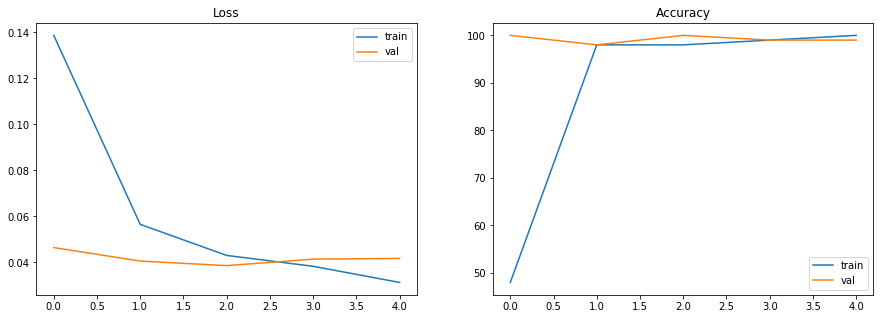

In [49]:
trainer.plot_performance()

## AlexNet

AlexNet was introduced in 2012, named after Alex Krizhevsky, the first author of the eponymous [paper](https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks). AlexNet uses an 8-layer convolutional neural network and won the ImageNet Large Scale Visual Recognition Challenge 2012 with a large margin. This network proved, for the first time, that the features obtained by learning can transcend manually-design features, breaking the previous paradigm in computer vision. The architectures of AlexNet and LeNet are *very similar*, as the diagram below illustrates. Note that we provide a slightly streamlined version of AlexNet which removes the quirks that were needed in 2012 to make the model fit on two small GPUs.

<img src="images/alexnet-all.svg" alt="">

The design philosophies of AlexNet and LeNet are very similar, but there are also significant differences.
First, AlexNet is much deeper than the comparatively small LeNet5. AlexNet consists of eight layers, five convolutional layers, two fully connected hidden layers, and one fully connected output layer. Second, AlexNet used the ReLU instead of the sigmoid as its activation function. This improved convergence during training significantly. Let's delve into the details below.

### Architecture

In AlexNet's first layer, the convolution window shape is $11\times11$. Since most images in ImageNet are more than ten times higher and wider than the MNIST images, objects in ImageNet images take up more pixels. Consequently, a larger convolution window is needed to capture the object. The convolution window shape in the second layer is reduced to $5\times5$, followed by $3\times3$. In addition, after the first, second, and fifth convolutional layers, the network adds maximum pooling layers with a window shape of $3\times3$ and a stride of 2. Moreover, AlexNet has ten times more convolution channels than LeNet.

After the last convolutional layer are two fully connected layers with 4096 outputs. These two huge fully connected layers produce model parameters of nearly 1 GB. Due to the limited memory in early GPUs, the original AlexNet used a dual data stream design, so that one GPU only needs to process half of the model. Fortunately, GPU memory has developed tremendously over the past few years, so we usually do not need this special design anymore (our model deviates from the original paper in this aspect).

### Activation Functions

Second, AlexNet changed the sigmoid activation function to a simpler ReLU activation function. On the one hand, the computation of the ReLU activation function is simpler. For example, it does not have the exponentiation operation found in the sigmoid activation function. On the other hand, the ReLU activation function makes model training easier when using different parameter initialization methods. This is because, when the output of the sigmoid activation function is very close to 0 or 1, the gradient of these regions is almost 0, so that back propagation cannot continue to update some of the model parameters. In contrast, the gradient of the ReLU activation function in the positive interval is always 1. Therefore, if the model parameters are not properly initialized, the sigmoid function may obtain a gradient of almost 0 in the positive interval, so that the model cannot be effectively trained.

### Capacity Control and Preprocessing

AlexNet controls the model complexity of the fully connected layer by [dropout](../chapter_deep-learning-basics/dropout.md) section), while LeNet only uses weight decay. To augment the data even further, the training loop of AlexNet added a great deal of image augmentation, such as flipping, clipping, and color changes. This makes the model more robust and the larger sample size effectively reduces overfitting. We will discuss preprocessing in detail in a [subsequent section](../chapter_computer-vision/image-augmentation.md).

## VGG Network

Like AlexNet and LeNet, the VGG Network is composed of convolutional layer modules attached to fully connected layers. Several `vgg_block` modules are connected in series in the convolutional layer module, the hyper-parameter of which is defined by the variable `conv_arch`. This variable specifies the numbers of convolutional layers and output channels in each VGG block. The fully connected module is the same as that of AlexNet.

<img src="images/vgg.svg" alt="">


The VGG network proposed by Simonyan and Ziserman has 5 convolutional blocks, among which the former two use a single convolutional layer, while the latter three use a double convolutional layer. The first block has 64 output channels, and the latter blocks double the number of output channels, until that number reaches 512. Since this network uses 8 convolutional layers and 3 fully connected layers, it is often called VGG-11.

# Networks Using Blocks (VGG)

AlexNet adds three convolutional layers to LeNet. Beyond that, the authors of AlexNet made significant adjustments to the convolution windows, the number of output channels, nonlinear activation, and regularization. Although AlexNet proved that deep convolutional neural networks can achieve good results, it does not provide simple rules to guide subsequent researchers in the design of new networks. In the following sections, we will introduce several different concepts used in deep network design.

Progress in this field mirrors that in chip design where engineers went from placing transistors (neurons) to logical elements (layers) to logic blocks  (the topic of the current section). The idea of using blocks was first proposed by the [Visual Geometry Group](http://www.robots.ox.ac.uk/~vgg/) (VGG) at Oxford University. This led to the VGG network, which we will be discussing below. When using a modern deep learning framework repeated structures can be expressed as *code* with for loops and subroutines. Just like we would use a for loop to count from 1 to 10, we'll use code to combine layers.

## VGG Blocks

The basic building block of a ConvNet is the combination of a convolutional layer (with padding to keep the resolution unchanged), followed by a nonlinearity such as a ReLu. A VGG block is given by a sequence of such layers, followed by maximum pooling. Throughout their design [Simonyan and Ziserman, 2014](https://arxiv.org/abs/1409.1556) used convolution windows of size 3 and maximum pooling with stride and window width 2, effectively halving the resolution after each block. We use the `vgg_block` function to implement this basic VGG block. This function takes the number of convolutional layers `num_convs` and the number of output channels `num_channels` as input.

In [ ]:
import sys
sys.path.insert(0, '..')

import d2l
from mxnet import gluon, init, nd
from mxnet.gluon import nn

def vgg_block(num_convs, num_channels):
    blk = nn.Sequential()
    for _ in range(num_convs):
        blk.add(nn.Conv2D(num_channels, kernel_size=3,
                          padding=1, activation='relu'))
    blk.add(nn.MaxPool2D(pool_size=2, strides=2))
    return blk

# Network in Network (NiN)

LeNet, AlexNet, and VGG all share a common design pattern: extract the spatial features through a sequence of convolutions and pooling layers and then post-process the representations via fully connected layers. The improvements upon LeNet by AlexNet and VGG mainly lie in how these later networks widen and deepen these two modules. An alternative is to use fully connected layers much earlier in the process. However, a careless use of a dense layer would destroy the spatial structure of the data entirely, since fully connected layers mangle all inputs. Network in Network (NiN) blocks offer an alternative. They were proposed by [Lin, Chen and Yan, 2013](https://arxiv.org/pdf/1312.4400.pdf) based on a very simple insight - to use an MLP on the channels for each pixel separately.

## NiN Blocks

We know that the inputs and outputs of convolutional layers are usually four-dimensional arrays (example, channel, height, width), while the inputs and outputs of fully connected layers are usually two-dimensional arrays (example, feature). This means that once we process data by a fully connected layer it's virtually impossible to recover the spatial structure of the representation. But we could apply a fully connected layer at a pixel level: Recall the $1\times 1$ convolutional layer described in the section discussing [channels](channels.md). This somewhat unusual convolution can be thought of as a fully connected layer processing channel activations on a per pixel level. Another way to view this is to think of each element in the spatial dimension (height and width) as equivalent to an example, and the channel as equivalent to a feature. NiNs use the $1\times 1$ convolutional layer instead of a fully connected layer. The spatial information can then be naturally passed to the subsequent layers. The figure below illustrates the main structural differences between NiN and AlexNet, VGG, and other networks.

<img src="images/nin-compare.svg" alt="">

The NiN block is the basic block in NiN. It concatenates a convolutional layer and two $1\times 1$ convolutional layers that act as fully connected layers (with ReLU in between). The convolution width of the first layer is typically set by the user. The subsequent widths are fixed to $1 \times 1$.

In [ ]:
import sys
sys.path.insert(0, '..')

import d2l
from mxnet import gluon, init, nd
from mxnet.gluon import nn

def nin_block(num_channels, kernel_size, strides, padding):
    blk = nn.Sequential()
    blk.add(nn.Conv2D(num_channels, kernel_size, strides, padding, activation='relu'),
            nn.Conv2D(num_channels, kernel_size=1, activation='relu'),
            nn.Conv2D(num_channels, kernel_size=1, activation='relu'))
    return blk

## NiN Model

NiN was proposed shortly after the release of AlexNet. Their convolutional layer settings share some similarities. NiN uses convolutional layers with convolution window shapes of $11\times 11$, $5\times 5$, and $3\times 3$, and the corresponding numbers of output channels are the same as in AlexNet. Each NiN block is followed by a maximum pooling layer with a stride of 2 and a window shape of $3\times 3$.

In addition to using NiN blocks, NiN’s design is significantly different from AlexNet by avoiding dense connections entirely: Instead, NiN uses a NiN block with a number of output channels equal to the number of label classes, and then uses a global average pooling layer to average all elements in each channel for direct use in classification. Here, the global average pooling layer, i.e. the window shape, is equal to the average pooling layer of the input spatial dimension shape. The advantage of NiN's design is that it can significantly reduce the size of model parameters, thus mitigating overfitting. In other words, short of the average pooling all operations are convolutions. However, this design sometimes results in an increase in model training time.

In [ ]:
net = nn.Sequential()
net.add(nin_block(96, kernel_size=11, strides=4, padding=0),
        nn.MaxPool2D(pool_size=3, strides=2),
        nin_block(256, kernel_size=5, strides=1, padding=2),
        nn.MaxPool2D(pool_size=3, strides=2),
        nin_block(384, kernel_size=3, strides=1, padding=1),
        nn.MaxPool2D(pool_size=3, strides=2),
        nn.Dropout(0.5),
        # There are 10 label classes
        nin_block(10, kernel_size=3, strides=1, padding=1),
        # The global average pooling layer automatically sets the window shape
        # to the height and width of the input
        nn.GlobalAvgPool2D(),
        # Transform the four-dimensional output into two-dimensional output
        # with a shape of (batch size, 10)
        nn.Flatten())

We create a data example to see the output shape of each block.

In [ ]:
X = nd.random.uniform(shape=(1, 1, 224, 224))
net.initialize()
for layer in net:
    X = layer(X)
    print(layer.name, 'output shape:\t', X.shape)

## Data Acquisition and Training

As before we use Fashion-MNIST to train the model. NiN's training is similar to that for AlexNet and VGG, but it often uses a larger learning rate.

In [ ]:
lr, num_epochs, batch_size, ctx = 0.1, 5, 128, d2l.try_gpu()
net.initialize(force_reinit=True, ctx=ctx, init=init.Xavier())
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': lr})
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=224)
d2l.train_ch5(net, train_iter, test_iter, batch_size, trainer, ctx,
              num_epochs)

## Summary

* NiN uses blocks consisting of a convolutional layer and multiple $1\times 1$ convolutional layer. This can be used within the convolutional stack to allow for more per-pixel nonlinearity.
* NiN removes the fully connected layers and replaces them with global average pooling (i.e. summing over all locations) after reducing the number of channels to the desired number of outputs (e.g. 10 for Fashion-MNIST).
* Removing the dense layers reduces overfitting. NiN has dramatically fewer parameters.
* The NiN design influenced many subsequent convolutional neural networks designs.

## Exercises

1. Tune the hyper-parameters to improve the classification accuracy.
1. Why are there two $1\times 1$ convolutional layers in the NiN block? Remove one of them, and then observe and analyze the experimental phenomena.
1. Calculate the resource usage for NiN
    * What is the number of parameters?
    * What is the amount of computation?
    * What is the amount of memory needed during training?
    * What is the amount of memory needed during inference?
1. What are possible problems with reducing the $384 \times 5 \times 5$ representation to a $10 \times 5 \times 5$ representation in one step?

# GoogLeNet (Inception Module v1)

Whenever I discuss or show [GoogleNet architecture](http://arxiv.org/pdf/1409.4842v1.pdf), one question always comes up - <br /><br />
**<center>"Why 1x1 convolution ? Is it not redundant ?</center>**

<center>
<img align="center" alt="Convolution with Kernel of size 3x3" src="https://raw.githubusercontent.com/iamaaditya/iamaaditya.github.io/master/images/conv_arithmetic/full_padding_no_strides_transposed.gif" />
<img align="center" alt="Convolution with Kernel of size 1x1" src="https://raw.githubusercontent.com/iamaaditya/iamaaditya.github.io/master/images/conv_arithmetic/full_padding_no_strides_transposed_small.gif" />
</center>
<center>
left : **Convolution with kernel of size 3x3**               right : **Convolution with kernel of size 1x1**
</center>



## Simple Answer

Most simplistic explanation would be that 1x1 convolution leads to dimension reductionality. For example, an image of 200 x 200 with 50 features on convolution with 20 filters of 1x1 would result in size of 200 x 200 x 20.
But then again, is this is the best way to do dimensionality reduction in the convoluational neural network? What about the efficacy vs efficiency?

## Complex Answer

### Feature transformation
Although 1x1 convolution is a 'feature pooling' technique, there is more to it than just sum pooling of features across various channels/feature-maps of a given layer. 
1x1 convolution acts like coordinate-dependent transformation in the filter space[[1](https://plus.google.com/118431607943208545663/posts/2y7nmBuh2ar)]. It is important to note here that this transformation is strictly linear, but in most of application of 1x1 convolution, it is succeeded by a non-linear activation layer like ReLU. This transformation is learned through the (stochastic) gradient descent. But an important distinction is that it suffers with less over-fitting due to smaller kernel size (1x1).

### Deeper Network

One by One convolution was first introduced in this paper titled [Network in Network](http://arxiv.org/pdf/1312.4400v3.pdf). In this paper, the author's goal was to generate a deeper network without simply stacking more layers. It replaces few filters with a smaller perceptron layer with mixture of 1x1 and 3x3 convolutions. In a way, it can be seen as "going wide" instead of "deep", but it should be noted that in machine learning terminology, 'going wide' is often meant as adding more data to the training. Combination of 1x1 (x F) convolution is mathematically equivalent to a multi-layer perceptron.[[2](https://www.reddit.com/r/MachineLearning/comments/3oln72/1x1_convolutions_why_use_them/cvyxood)]. 

**Inception Module**

In GoogLeNet architecture, 1x1 convolution is used for two purposes 

  * To make network deep by adding an "inception module" like Network in Network paper, as described above.
  * To reduce the dimensions inside this "inception module".
  * To add more non-linearity by having ReLU immediately after every 1x1 convolution.

Here is the scresnshot from the paper, which elucidates above points :

<center>
<img src="https://raw.githubusercontent.com/iamaaditya/iamaaditya.github.io/master/images/inception_1x1.png" alt="1x1 convolutions in GoogLeNet" />
</center>
**<center>1x1 convolutions in GoogLeNet</center>**

It can be seen from the image on the right, that 1x1 convolutions (in yellow), are specially used before 3x3 and 5x5 convolution to reduce the dimensions. It should be noted that a two step convolution operation can always to combined into one, but in this case and in most other deep learning networks, convolutions are followed by non-linear activation and hence convolutions are no longer linear operators and cannot be combined.


In designing such a network, it is important to note that initial convolution kernel should be of size larger than 1x1 to have a receptive field capable of capturing locally spatial information. According to the NIN paper, 1x1 convolution is equivalent to cross-channel parametric pooling layer. From the paper - "This cascaded cross channel parameteric pooling structure allows complex and learnable interactions of cross channel information".

Cross channel information learning (cascaded 1x1 convolution) is biologically inspired because human visual cortex have receptive fields (kernels) tuned to different orientation. For e.g 

![different orientation tuned receptive field profiles in the human visual cortex](https://raw.githubusercontent.com/iamaaditya/iamaaditya.github.io/master/images/conv_arithmetic/RotBundleFiltersListPlot3D.gif)



**Different orientation tuned receptive field profiles in the human visual cortex** [Source](http://bmia.bmt.tue.nl/education/courses/fev/course/notebooks/Convolution.html)



## More Uses

  * 1x1 Convolution can be combined with Max pooling

  ![Pooling with 1x1 convolution](https://raw.githubusercontent.com/iamaaditya/iamaaditya.github.io/master/images/conv_arithmetic/numerical_max_pooling.gif)
   **Pooling with 1x1 convolution**
  <br />

  * 1x1 Convolution with higher strides leads to even more redution in data by decreasing resolution, while losing very little non-spatially correlated information.

  ![1x1 convolution with strides](https://raw.githubusercontent.com/iamaaditya/iamaaditya.github.io/master/images/conv_arithmetic/no_padding_strides.gif)
   **1x1 convolution with strides**
   <br />

  * Replace fully connected layers with 1x1 convolutions as Yann LeCun believes they are the same -
> In Convolutional Nets, there is no such thing as "fully-connected layers". There are only convolution layers with 1x1 convolution kernels and a full connection table.
-- [Yann LeCun](https://www.facebook.com/yann.lecun/posts/10152820758292143)
  <br />

*Convolution gif images generated using [this wonderful code](https://github.com/vdumoulin/conv_arithmetic), more images on 1x1 convolutions and 3x3 convolutions can be* [found here](http://gpgpu.cs-i.brandeis.edu/convolution_images/)


# Residual Networks (ResNet)

As we design increasingly deeper networks it becomes imperative to understand how adding layers can increase the complexity and expressiveness of the network. Even more important is the ability to design networks where adding layers makes networks strictly more expressive rather than just different. To make some progress we need a bit of theory. 

## Function Classes

Consider $\mathcal{F}$, the class of functions that a specific network architecture (together with learning rates and other hyperparameter settings) can reach. That is, for all $f \in \mathcal{F}$ there exists some set of parameters $W$ that can be obtained through training on a suitable dataset. Let's assume that $f^*$ is the function that we really would like to find. If it's in $\mathcal{F}$, we're in good shape but typically we won't be quite so lucky. Instead, we will try to find some $f^*_\mathcal{F}$ which is our best bet within $\mathcal{F}$. For instance, we might try finding it by solving the following optimization problem:

$$f^*_\mathcal{F} := \mathop{\mathrm{argmin}}_f L(X, Y, f) \text{ subject to } f \in \mathcal{F}$$

It is only reasonable to assume that if we design a different and more powerful architecture $\mathcal{F}'$ we should arrive at a better outcome. In other words, we would expect that $f^*_{\mathcal{F}'}$ is 'better' than $f^*_{\mathcal{F}}$. However, if $\mathcal{F} \not\subseteq \mathcal{F}'$ there is no guarantee that this should even happen. In fact, $f^*_{\mathcal{F}'}$ might well be worse. This is a situation that we often encounter in practice - adding layers doesn't only make the network more expressive, it also changes it in sometimes not quite so predictable ways. The picture below illustrates this in slightly abstract terms. 

<img src="images/functionclasses.svg" alt="">


Only if larger function classes contain the smaller ones are we guaranteed that increasing them strictly increases the expressive power of the network. This is the question that He et al, 2016 considered when working on very deep computer vision models. At the heart of ResNet is the idea that every additional layer should contain the identity function as one of its elements. This means that if we can train the newly-added layer into an identity mapping $f(\mathbf{x}) = \mathbf{x}$, the new model will be as effective as the original model. As the new model may get a better solution to fit the training data set, the added layer might make it easier to reduce training errors. Even better, the identity function rather than the null $f(\mathbf{x}) = 0$ should be the the simplest function within a layer. 

These considerations are rather profound but they led to a surprisingly simple solution, a residual block. With it, [He et al, 2015](https://arxiv.org/abs/1512.03385) won the ImageNet Visual Recognition Challenge in 2015. The design had a profound influence on how to build deep neural networks.


## Residual Blocks

Let us focus on a local neural network, as depicted below. Denote the input by $\mathbf{x}$. We assume that the ideal mapping we want to obtain by learning is $f(\mathbf{x})$, to be used as the input to the activation function. The portion within the dotted-line box in the left image must directly fit the mapping $f(\mathbf{x})$. This can be tricky if we don't need that particular layer and we would much rather retain the input $\mathbf{x}$. The portion within the dotted-line box in the right image now only needs to parametrize the *deviation* from the identity, since we return $\mathbf{x} + f(\mathbf{x})$. In practice, the residual mapping is often easier to optimize. We only need to set $f(\mathbf{x}) = 0$. The right image in the figure below illustrates the basic Residual Block of ResNet. Similar architectures were later proposed for sequence models which we will study later. 

<img src="images/residual-block.svg" alt="">

ResNet follows VGG's full $3\times 3$ convolutional layer design. The residual block has two $3\times 3$ convolutional layers with the same number of output channels. Each convolutional layer is followed by a batch normalization layer and a ReLU activation function. Then, we skip these two convolution operations and add the input directly before the final ReLU activation function. This kind of design requires that the output of the two convolutional layers be of the same shape as the input, so that they can be added together. If we want to change the number of channels or the the stride, we need to introduce an additional $1\times 1$ convolutional layer to transform the input into the desired shape for the addition operation. Let's have a look at the code below.

This code generates two types of networks: one where we add the input to the output before applying the ReLU nonlinearity, and whenever `use_1x1conv=True`, one where we adjust channels and resolution by means of a $1 \times 1$ convolution before adding. The diagram below illustrates this:

<img src="images/ResNetBlock.svg" alt="">

Now let us look at a situation where the input and output are of the same shape.

## Residual Learning
It is possible to fit an desired underlying mapping $H(x)$ by a few stacked nonlinear layers, so they can also fit an another underlying mapping $F(x)=H(x)−x$. As a result, it is possible to reformulate it to $H(x)=F(x)+x$, which consists of the Residual Function $F(x)$ and input $x$. The connection of the input to the output is called a skipt connection or identity mapping. The general idea is that if multiple nonlinear layers can approximate the complicated function $H(x)$, then it is possible for them to approximate the residual function $F(x)$. Therefore the stacked layers are not used to fit $H(x)$, instead these layers approximate the residual function $F(x)$. Both forms should be able to fit the underlying mapping.

<img src="images/residual_building_block.png" alt="">

One reason for the degradation problem could be the difficulties in approximating identity mappings by nonlinear layers. The reformulation used identity mapping as a reference and let the residual function represent the perturbations. The identity mapping can be generated by the solver through driving the weights of the residual function to zero if need be.

### Implementation
Residual learning is implented to every few stacked layers. Figure 2 shows an example of 2 layers. As an example, formulation (1) can be defined as:

(1)                                $$F(x)=W_2σ(W_1x)+x $$

Where W1 and W2 are the weights for the convolutinoal layers and σ is the activation function, in this case a RELU function. The operation F+x is realized by a shortcut connection and element-wise addition. The addition is followed by an activation function σ.

The resulting formulation for a residual block is:

(2)                                $$y(x)=σ(W_2σ(W_1x)+x) .$$

After each convolution (weight) layer a batch normalization method (BN) is adopted. The training of the network is achiebed by stochastic gradient descent (SGD) with a mini-batch size of 256. The learning rate starts from 0.1 and is divided by 10 when the error plateaus. The weight decay rate is 0.0001 and has a value of 0.9. (1)

### Residual Network
To convert the plain model to the residual version, shortcut connections are added, as demonstrated in the figure 3 (right). The solid line shortcuts are identity mapping. When the dimensions increases there are 2 options (dotted line shortcut):

1. The shortcut still performs identity mapping with zero padding to increasing the dimensions or

2. the shortcut is used to match dimensions utilizing 1x1 convolution.

In both options, when the shortcut go across feature maps of different sizes, they used a stride of 2. Generally the second option is used.(1)

<img src="images/residual_block.png" alt="">


## Data

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms


# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper-parameters
num_epochs = 80
learning_rate = 0.001

# Image preprocessing modules
transform = transforms.Compose([
    transforms.Pad(4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32),
    transforms.ToTensor()])

# CIFAR-10 dataset
train_dataset = torchvision.datasets.CIFAR10(root='../../data/',
                                             train=True, 
                                             transform=transform,
                                             download=True)

test_dataset = torchvision.datasets.CIFAR10(root='../../data/',
                                            train=False, 
                                            transform=transforms.ToTensor())

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=100, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=100, 
                                          shuffle=False)

## Residual bloack

In [4]:
# 3x3 convolution
def conv3x3(in_channels, out_channels, stride=1):
    return nn.Conv2d(in_channels, out_channels, kernel_size=3, 
                     stride=stride, padding=1, bias=False)

# Residual block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = conv3x3(in_channels, out_channels, stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(out_channels, out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample
        
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

## ResNet

In [6]:
# ResNet
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 16
        self.conv = conv3x3(3, 16)
        self.bn = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self.make_layer(block, 16, layers[0])
        self.layer2 = self.make_layer(block, 32, layers[1], 2)
        self.layer3 = self.make_layer(block, 64, layers[2], 2)
        self.avg_pool = nn.AvgPool2d(8)
        self.fc = nn.Linear(64, num_classes)
        
    def make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if (stride != 1) or (self.in_channels != out_channels):
            downsample = nn.Sequential(
                conv3x3(self.in_channels, out_channels, stride=stride),
                nn.BatchNorm2d(out_channels))
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for i in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)
    
    def forward(self, x):
        out = self.conv(x)
        out = self.bn(out)
        out = self.relu(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

## Model

In [ ]:
model = ResNet(ResidualBlock, [2, 2, 2]).to(device)


# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# For updating learning rate
def update_lr(optimizer, lr):    
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

# Train the model
total_step = len(train_loader)
curr_lr = learning_rate
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print ("Epoch [{}/{}], Step [{}/{}] Loss: {:.4f}"
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

    # Decay learning rate
    if (epoch+1) % 20 == 0:
        curr_lr /= 3
        update_lr(optimizer, curr_lr)

# Test the model
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the model on the test images: {} %'.format(100 * correct / total))

# Save the model checkpoint
torch.save(model.state_dict(), 'resnet.ckpt')

# Plain Networks
Before talking about Highway Networks, Let’s start with plain network which consists of $L$ layers where the $l-th$ layer (with omitting the symbol for layer):


$$y=H(x, W_H)$$


where $x$ is input, $W_H$ is the weight, $H$ is the transform function followed by an activation function and $y$ is the output. And for $i-th$ unit:

$$y_i=H_i(x)$$

We compute the $y_i$ and pass it to next layer.


The plain networks are adopted from the VGG nets (Figure 3(left)). The convolutional layers have mostly 3x3 filters and the design follows two rules:
1. For the same output feature map size, the layers have the same number of filters, and

2. if the feature map size is halved, the number of filters is doubled in order to preserve the time complexity per layer.

The downsampling operation is performed by the convolutional layers that have a stride of 2, hence no pooling layers. The network ends with a global average pooling layer and a 1000-way fully connected layer with softmax function.

Figure 3 (middle) shows a plain model with 34 layers. (1)

<img src="images/residualnet_34.png" alt="">

# Highway Networks

<img src="images/highway.png" alt="">


In highway network, two non-linear transforms $T$ and $C$ are introduced:

$$y= H(x, W_H).T(x, W_T) + x . C(x, W_C)$$

where $T$ is the Transform Gate and $C$ is the Carry Gate. In particular, $C = 1 - T$:

$$y= H(x, W_H).T(x, W_T) + x . (1 - T(x, W_T))$$

We can have below conditions for particular T values:


$$
\begin{split}y =
\begin{cases}
x & \text{if } T(x, W_T) = 0 \\
H(x, W_H) & \text{if } T(x, W_T) = 1
\end{cases}
\end{split}
$$


When $T=0$, we pass the input as output directly which creates an information highway. That’s why it is called Highway Network !!!. When $T=1$, we use the non-linear activated transformed input as output. Here, in contrast to the $i-th$ unit in plain network, authors introduce the block concept. For $i-th$ block, there is a block state $H_i(x)$, and and transform gate output $T_i(x)$. And the corresponding block output $y_i$:

$$y_i= H_i(x, W_H)*T_i(x, W_T) + x_i . (1 - T_i(x))$$

which is connected to the next layer. Formally, $T(x)$ is the sigmoid function:

$$T(x) = \sigma(W^T_Tx + b_T)$$


# Densely Connected Networks (DenseNet)

ResNet significantly changed the view of how to parametrize the functions in deep networks. DenseNet is to some extent the logical extension of this. To understand how to arrive at it, let's take a small detour to theory. Recall the Taylor expansion for functions. For scalars it can be written as

$$f(x) = f(0) + f'(x) x + \frac{1}{2} f''(x) x^2 + \frac{1}{6} f'''(x) x^3 + o(x^3)$$

## Function Decomposition

The key point is that it decomposes the function into increasingly higher order terms. In a similar vein, ResNet decomposes functions into 

$$f(\mathbf{x}) = \mathbf{x} + g(\mathbf{x})$$

That is, ResNet decomposes $f$ into a simple linear term and a more complex nonlinear one. What if we want to go beyond two terms? A solution was proposed by [Huang et al, 2016](https://arxiv.org/abs/1608.06993) in the form of DenseNet, an architecture that reported record performance on the ImageNet dataset. 

![The main difference between ResNet (left) and DenseNet (right) in cross-layer connections: use of addition and use of concatenation. ](../img/densenet.svg)

The key difference between ResNet and DenseNet is that in the latter case outputs are *concatenated* rather than added. As a result we perform a mapping from $\mathbf{x}$ to its values after applying an increasingly complex sequence of functions.

$$\mathbf{x} \to \left[\mathbf{x}, f_1(\mathbf{x}), f_2(\mathbf{x}, f_1(\mathbf{x})), f_3(\mathbf{x}, f_1(\mathbf{x}), f_2(\mathbf{x}, f_1(\mathbf{x})), \ldots\right]$$

In the end, all these functions are combined in an MLP to reduce the number of features again. In terms of implementation this is quite simple - rather than adding terms, we concatenate them. The name DenseNet arises from the fact that the dependency graph between variables becomes quite dense. The last layer of such a chain is densely connected to all previous layers. The main components that compose a DenseNet are dense blocks and transition layers. The former defines how the inputs and outputs are concatenated, while the latter controls the number of channels so that it is not too large.

![Dense connections in DenseNet](../img/DenseNetDense.svg)

## Dense Blocks

DenseNet uses the modified "batch normalization, activation, and convolution" architecture of ResNet (see the exercise in the [previous section](resnet.md)). First, we implement this architecture in the `conv_block` function.


In [1]:
import sys
sys.path.insert(0, '..')

import d2l
from mxnet import gluon, init, nd
from mxnet.gluon import nn

def conv_block(num_channels):
    blk = nn.Sequential()
    blk.add(nn.BatchNorm(), 
            nn.Activation('relu'),
            nn.Conv2D(num_channels, kernel_size=3, padding=1))
    return blk

ModuleNotFoundError: No module named 'd2l'

A dense block consists of multiple `conv_block` units, each using the same number of output channels. In the forward computation, however, we concatenate the input and output of each block on the channel dimension.

In [2]:
class DenseBlock(nn.Block):
    def __init__(self, num_convs, num_channels, **kwargs):
        super(DenseBlock, self).__init__(**kwargs)
        self.net = nn.Sequential()
        for _ in range(num_convs):
            self.net.add(conv_block(num_channels))

    def forward(self, X):
        for blk in self.net:
            Y = blk(X)
            # Concatenate the input and output of each block on the channel
            # dimension
            X = nd.concat(X, Y, dim=1)
        return X

NameError: name 'nn' is not defined

In the following example, we define a convolution block with two blocks of 10 output channels. When using an input with 3 channels, we will get an output with the $3+2\times 10=23$ channels. The number of convolution block channels controls the increase in the number of output channels relative to the number of input channels. This is also referred to as the growth rate.


## Transition Layers

Since each dense block will increase the number of channels, adding too many of them will lead to an excessively complex model. A transition layer is used to control the complexity of the model. It reduces the number of channels by using the $1\times 1$ convolutional layer and halves the height and width of the average pooling layer with a stride of 2, further reducing the complexity of the model.


In [3]:
def transition_block(num_channels):
    blk = nn.Sequential()
    blk.add(nn.BatchNorm(), nn.Activation('relu'),
            nn.Conv2D(num_channels, kernel_size=1),
            nn.AvgPool2D(pool_size=2, strides=2))
    return blk

Apply a transition layer with 10 channels to the output of the dense block in the previous example.  This reduces the number of output channels to 10, and halves the height and width.

In [4]:
blk = transition_block(10)
blk.initialize()
blk(Y).shape

NameError: name 'nn' is not defined

## DenseNet Model

Next, we will construct a DenseNet model. DenseNet first uses the same single convolutional layer and maximum pooling layer as ResNet.